TODO: remove this, and make sure this works on main.

In [1]:
%%bash

[ ! -d "ocp" ] && git clone https://github.com/emsunshine/ocp.git

cd ocp
git pull
git checkout ase_datasets_bugfixes
pip install -e .
git rev-parse HEAD
echo "Restart the kernel"

Already up to date.


Already on 'ase_datasets_bugfixes'


Your branch is up to date with 'origin/ase_datasets_bugfixes'.
Obtaining file:///home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/ocp
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for ocp-models (pyproject.toml): started
  Building editable for ocp-models (pyproject.toml): finished with status 'done'
  Created wheel for ocp-models: filename=ocp_models-0.0.3-0.editable-py3-none-any.whl size=3335 sha256=f20441fcd6b80e9a8a36439516d866e7294c403bdb19b1cbfac8d155c161e245
  Stored in directory: /tmp/pip-ephem-w

# Fine tuning a model

In this section we look at how to improve a model. We start by using a pre-trained model to predict the energies of several oxide polymorphs. The data here comes from this paper:

Identifying Potential BO2 Oxide Polymorphs for Epitaxial Growth Candidates
Mehta, P., Salvador, P. A., & Kitchin, J. R. (2015). Identifying potential BO2 oxide polymorphs for epitaxial growth candidates. ACS Appl. Mater. Interfaces, 6(5), 3630–3639. http://dx.doi.org/10.1021/am4059149

This data set shows equations of state for several oxide/polymorph combinations. I use this dataset to compare with predictions from OCP

First we get the checkpoint that we want. According to the [MODELS](https://github.com/Open-Catalyst-Project/ocp/blob/main/MODELS.md#s2ef-models) the GemNet-OC	OC20+OC22 combination has an energy MAE of 0.483 which seems like a good place to start. This model was trained on oxides.

We get this checkpoint here.

In [2]:
%run ../ocp-tutorial.ipynb  # load some helper functions
checkpoint = get_checkpoint('GemNet-OC OC20+OC22')

The data we need is provided in `supporting-information.json`. That file is embedded in the supporting information for the article, and is provided here in the tutorial. We load this data and explore it a little. The json file provides a dictionary with the structure:

    [oxide][polymorph][xc][EOS][configurations]
    
The first key is a composition, the second is a string for the polymorph structure, the third indicates which XC functional was used (we focus on PBE here), the fourth key is for the Equation of State calculations, and the last key is a list of results for the EOS. 

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms

with open('supporting-information.json', 'rb') as f:
     d = json.loads(f.read())
        

oxides = list(d.keys())
polymorphs = list(d['TiO2'].keys())
oxides, polymorphs

(['SnO2', 'IrO2', 'RuO2', 'TiO2', 'VO2'],
 ['rutile', 'pyrite', 'columbite', 'brookite', 'fluorite', 'anatase'])

A specific calculation has a lot of details in it. You can use this to recreate the calculations. Shortly we will use these to compare the DFT results to OCP.

In [4]:
d['TiO2']['rutile']['PBE']['EOS']['calculations'][0]

{'incar': {'doc': 'INCAR parameters',
  'prec': 'Normal',
  'isif': 4,
  'nbands': 20,
  'ibrion': 2,
  'gga': 'PE',
  'encut': 520.0,
  'ismear': 0,
  'sigma': 0.001,
  'nsw': 50},
 'doc': 'JSON representation of a VASP calculation.\n\nenergy is in eV\nforces are in eV/\\AA\nstress is in GPa (sxx, syy, szz,  syz, sxz, sxy)\nmagnetic moments are in Bohr-magneton\nThe density of states is reported with E_f at 0 eV.\nVolume is reported in \\AA^3\nCoordinates and cell parameters are reported in \\AA\n\nIf atom-projected dos are included they are in the form:\n{ados:{energy:data, {atom index: {orbital : dos}}}\n',
 'potcar': [['O',
   'potpaw/O/POTCAR',
   '0cf2ce56049ca395c567026b700ed66c94a85161'],
  ['Ti', 'potpaw/Ti/POTCAR', '51f7f05982d6b4052becc160375a8b8b670177a7']],
 'input': {'kpts': [6, 6, 6],
  'reciprocal': False,
  'xc': 'LDA',
  'kpts_nintersections': None,
  'setups': None,
  'txt': '-',
  'gamma': False},
 'atoms': {'cell': [[4.3789762519649225, 0.0, 0.0],
   [0.0, 4.378976

For each result we can retrieve the atomic geometry, energy and forces from the json file. We use these to recreate an Atoms object. Here is an example.

In [5]:
c = d['TiO2']['rutile']['PBE']['EOS']['calculations'][0]
atoms = Atoms(symbols=c['atoms']['symbols'],
              positions=c['atoms']['positions'],
              cell=c['atoms']['cell'],
              pbc=c['atoms']['pbc'])
atoms.set_tags(np.ones(len(atoms)))
atoms, c['data']['total_energy'], c['data']['forces']

(Atoms(symbols='Ti2O4', pbc=True, cell=[4.3789762519649225, 4.3789762519649225, 2.864091775985314], tags=...),
 -56.230672,
 [[0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [-0.001264, -0.001264, 0.0],
  [0.001264, 0.001264, 0.0],
  [-0.001264, 0.001264, 0.0],
  [0.001264, -0.001264, 0.0]])

Next, we will create an OCP calculator that we can use to get predictions from.

In [6]:
from ocpmodels.common.relaxation.ase_utils import OCPCalculator
calc = OCPCalculator(checkpoint=checkpoint, trainer='forces', cpu=False)

amp: false
cmd:
  checkpoint_dir: /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/checkpoints/2023-07-20-15-21-36
  commit: 999c1ac
  identifier: ''
  logs_dir: /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/logs/tensorboard/2023-07-20-15-21-36
  print_every: 100
  results_dir: /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/results/2023-07-20-15-21-36
  seed: null
  timestamp_id: 2023-07-20-15-21-36
dataset: null
gpus: 1
logger: tensorboard
model: gemnet_oc
model_attributes:
  activation: silu
  atom_edge_interaction: true
  atom_interaction: true
  cbf:
    name: spherical_harmonics
  cutoff: 12.0
  cutoff_aeaint: 12.0
  cutoff_aint: 12.0
  cutoff_qint: 12.0
  direct_forces: true
  edge_atom_interaction: true
  emb_size_aint_in: 64
  emb_size_aint_out: 64
  emb_size_atom: 256
  emb_size_cbf: 16
  emb_size_edge: 512
  emb_size_quad_in: 32
  emb_size_quad_out: 32
  emb_size_rbf: 16
  emb_size_sbf: 32
  emb_size_trip_

Now, we loop through each structure and accumulate the OCP predictions. Then, we plot the parity results.

Elapsed time 16.6 seconds.


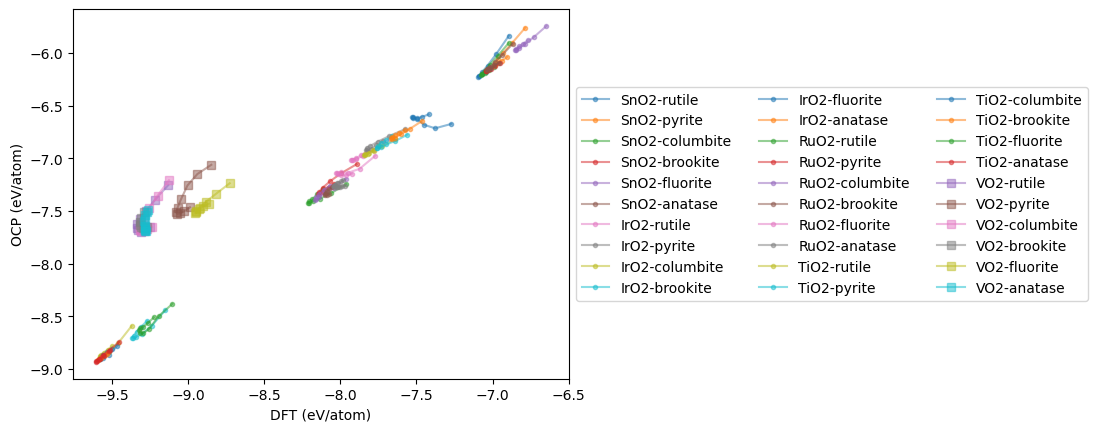

In [7]:
import time
t0 = time.time()

eos_data = {}
for oxide in oxides:
    eos_data[oxide] = {}
    for polymorph in polymorphs:
        dft = []
        ocp = []
        vols = []
        calculations = d[oxide][polymorph]['PBE']['EOS']['calculations']
        for c in calculations:
                        
            atoms = Atoms(symbols=c['atoms']['symbols'],
                          positions=c['atoms']['positions'],
                          cell=c['atoms']['cell'],
                          pbc=c['atoms']['pbc'])
            atoms.set_tags(np.ones(len(atoms)))
            
            atoms.calc = calc
            ocp += [atoms.get_potential_energy() / len(atoms)]
            dft += [c['data']['total_energy'] / len(atoms)]
            vols += [atoms.get_volume()]
        plt.plot(dft, ocp, marker='s' if oxide == 'VO2' else '.',
                 alpha=0.5, label=f'{oxide}-{polymorph}')
        eos_data[oxide][polymorph] = (vols, dft, ocp)
        
plt.xlabel('DFT (eV/atom)')
plt.ylabel('OCP (eV/atom)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=3);
print(f'Elapsed time {time.time() - t0:1.1f} seconds.')

In [8]:
mae = np.mean(np.abs(np.array(dft) - np.array(ocp)))
print(f'MAE = {mae:1.3f} eV/atom')

MAE = 1.668 eV/atom


The MAE is somewhat high compared to the reported value of 0.458 eV. That is not too surprising; although OC22 was trained on oxides, it was not trained on all of these structures. It is also evident on inspection that the main issues are all the VO2 structures, and these skew the MAE. Next we look at the EOS for each material. Here you can see offsets, and qualitative issues in the shapes. The offset is largely a PBE/RPBE difference.

Some notable issues are with fluorite structures

In [9]:
os.makedirs('pretrained-eos', exist_ok=True)
for oxide in eos_data:
    for polymorph in eos_data[oxide]:
        V, D, O = eos_data[oxide][polymorph]
        plt.figure()
        plt.plot(V, D, label='dft')
        plt.plot(V, O, label='ocp')
        plt.title(f'pretrained {oxide} - {polymorph}')
        plt.legend()
        plt.savefig(f'pretrained-eos/pretrained-{oxide}-{polymorph}.png')
        plt.close()

Here is one example from [pretrained-eos](./pretrained-eos).

![img](./pretrained-eos/pretrained-VO2-fluorite.png)

We can improve this by fine-tuning the model.

# Fine tuning the checkpoint

There are severeal steps in fine-tuning:
1. Create train, test, val datasets
2. Create a configuration yml file
3. Run the training
4. Check the results

First we create the training databases. OCP supports ase databases, so we use those here. The first step is to make a database containing the data. We need to write an atoms object with an attached SinglePointCalculator for each structure.

In [10]:
from ase.db import connect
from ase.calculators.singlepoint import SinglePointCalculator

! rm -fr oxides.db  # start clean when you run this cell
db = connect('oxides.db')

In [11]:
for oxide in oxides:
    for polymorph in polymorphs:
        for c in d[oxide][polymorph]['PBE']['EOS']['calculations']:
            atoms = Atoms(symbols=c['atoms']['symbols'],
                          positions=c['atoms']['positions'],
                          cell=c['atoms']['cell'],
                          pbc=c['atoms']['pbc'])
            atoms.set_tags(np.ones(len(atoms)))
            calc = SinglePointCalculator(atoms, 
                                         energy=c['data']['total_energy'],
                                         forces=c['data']['forces'])
            atoms.set_calculator(calc)
            db.write(atoms)

Let's see what we made.

In [12]:
! ase db oxides.db

id|age|formula|calculator| energy|natoms| fmax|pbc| volume|charge|   mass
 1| 3s|Sn2O4  |unknown   |-41.359|     6|0.045|TTT| 64.258| 0.000|301.416
 2| 3s|Sn2O4  |unknown   |-41.853|     6|0.025|TTT| 66.526| 0.000|301.416
 3| 3s|Sn2O4  |unknown   |-42.199|     6|0.010|TTT| 68.794| 0.000|301.416
 4| 3s|Sn2O4  |unknown   |-42.419|     6|0.006|TTT| 71.062| 0.000|301.416
 5| 3s|Sn2O4  |unknown   |-42.534|     6|0.011|TTT| 73.330| 0.000|301.416
 6| 3s|Sn2O4  |unknown   |-42.562|     6|0.029|TTT| 75.598| 0.000|301.416
 7| 3s|Sn2O4  |unknown   |-42.518|     6|0.033|TTT| 77.866| 0.000|301.416
 8| 3s|Sn2O4  |unknown   |-42.415|     6|0.010|TTT| 80.134| 0.000|301.416
 9| 3s|Sn2O4  |unknown   |-42.266|     6|0.006|TTT| 82.402| 0.000|301.416
10| 3s|Sn2O4  |unknown   |-42.083|     6|0.017|TTT| 84.670| 0.000|301.416
11| 3s|Sn4O8  |unknown   |-81.424|    12|0.012|TTT|117.473| 0.000|602.832
12| 3s|Sn4O8  |unknown   |-82.437|    12|0.005|TTT|121.620| 0.000|602.832
13| 3s|Sn4O8  |unknown   |-83.147|    

## Make the train, test, val splits

We need to split the ase-db into three separate databases, one for training (80%), one for testing (10%) and one for validation. We generate a list of ids and then shuffle them. Then we write the first 80% into `train.db`, the next 10% into `test.db`, and the remaining into `val.db`.

The train set is used for training. The test and val sets are used to check for overfitting.

You choose the splits you want, 80:10:10 is common. We take a simple approach to split the database here. We make an array of integers that correspond to the ids, randomly shuffle them, and then get each row in the randomized order and write them to a new db.

We provide some helper functions in [../ocp-tutorial.ipynb](../ocp-tutorial.ipynb) to streamline this process. 

In [13]:
! rm -fr train.db test.db val.db
train, test, val = train_test_val_split('oxides.db')
train, test, val

(PosixPath('/home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/train.db'),
 PosixPath('/home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/test.db'),
 PosixPath('/home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/val.db'))

## Setting up the configuration yaml file

We have to create a yaml configuration file for the model we are using. The pre-trained checkpoints contain their config data, so we use this to get the base configuration, and then remove pieces we don't need, and update pieces we do need.

In [14]:
yml = generate_yml_config(checkpoint, 'config.yml',
                   delete=['slurm', 'cmd', 'logger', 'task', 'model_attributes',
                           'optim.loss_force', # the checkpoint setting causes an error
                           'dataset', 'test_dataset', 'val_dataset'],
                   update={'gpus': 1,
                           'task.dataset': 'ase_db',
                           'optim.eval_every': 1,
                           'optim.max_epochs': 80,
                           # Train data
                           'dataset.train.src': 'train.db',
                           'dataset.train.a2g_args.r_energy': True,
                           'dataset.train.a2g_args.r_forces': True,
                            # Test data - prediction only so no regression
                           'dataset.test.src': 'test.db',
                           'dataset.test.a2g_args.r_energy': False,
                           'dataset.test.a2g_args.r_forces': False,
                           # val data
                           'dataset.val.src': 'val.db',
                           'dataset.val.a2g_args.r_energy': True,
                           'dataset.val.a2g_args.r_forces': True,
                          })

yml

PosixPath('/home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/config.yml')

In [15]:
! cat config.yml

amp: true
checkpoint: gnoc_oc22_oc20_all_s2ef.pt
dataset:
  test:
    a2g_args:
      r_energy: false
      r_forces: false
    src: test.db
  train:
    a2g_args:
      r_energy: true
      r_forces: true
    src: train.db
  val:
    a2g_args:
      r_energy: true
      r_forces: true
    src: val.db
gpus: 1
model:
  activation: silu
  atom_edge_interaction: true
  atom_interaction: true
  cbf:
    name: spherical_harmonics
  cutoff: 12.0
  cutoff_aeaint: 12.0
  cutoff_aint: 12.0
  cutoff_qint: 12.0
  direct_forces: true
  edge_atom_interaction: true
  emb_size_aint_in: 64
  emb_size_aint_out: 64
  emb_size_atom: 256
  emb_size_cbf: 16
  emb_size_edge: 512
  emb_size_quad_in: 32
  emb_size_quad_out: 32
  emb_size_rbf: 16
  emb_size_sbf: 32
  emb_size_trip_in: 64
  emb_size_trip_out: 64
  envelope:
    exponent: 5
    name: polynomial
  extensive: true
  forces_coupled: false
  max_neighbors: 30
  max_neighbors_aeaint: 20
  max_neighbors_aint: 1000
  max_neighbors_qint: 8
  name: gemne

## Running the training job

`ocp` provides a `main.py` file that is used for training. Here we construct the Python command you need to run, and run it. `main.py` is not executable, so we have to run it with python, and you need the absolute path to it, which we get from the `ocp_main()` that is defined in the [utilities](../ocp-tutorial.ipynb).

you must set a `mode` and provide a `config-yml`. We provide a checkpoint for a starting point, if you don't do this, it will start from scratch. 

By default the files that are created go in a directories called `checkpoints`, `logs` and `results`. You can change that with a `--run-dir preferred-place` option.

You can also add an identifier tag to the end of the timestamps with `--identifier tag`. This can make it easier to find them later.

The cell below uses some IPython magic to put Python variables in the shell command.

This command takes some time to run even on a GPU, e.g. about 30 minutes. 

In [16]:
! python {ocp_main()} --mode train --config-yml $yml --checkpoint $checkpoint \
  --run-dir fine-tuning --identifier ft-oxides --amp

2023-07-20 15:22:20 (INFO): Project root: /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/ocp
amp: true
cmd:
  checkpoint_dir: fine-tuning/checkpoints/2023-07-20-15-21-36-ft-oxides
  commit: 999c1ac
  identifier: ft-oxides
  logs_dir: fine-tuning/logs/tensorboard/2023-07-20-15-21-36-ft-oxides
  print_every: 10
  results_dir: fine-tuning/results/2023-07-20-15-21-36-ft-oxides
  seed: 0
  timestamp_id: 2023-07-20-15-21-36-ft-oxides
dataset:
  a2g_args:
    r_energy: true
    r_forces: true
  src: train.db
gpus: 1
logger: tensorboard
model: gemnet_oc
model_attributes:
  activation: silu
  atom_edge_interaction: true
  atom_interaction: true
  cbf:
    name: spherical_harmonics
  cutoff: 12.0
  cutoff_aeaint: 12.0
  cutoff_aint: 12.0
  cutoff_qint: 12.0
  direct_forces: true
  edge_atom_interaction: true
  emb_size_aint_in: 64
  emb_size_aint_out: 64
  emb_size_atom: 256
  emb_size_cbf: 16
  emb_size_edge: 512
  emb_size_quad_in: 32
  emb_size_quad_out: 32
  emb_size_

2023-07-20 15:22:46 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.45it/s]
2023-07-20 15:22:47 (INFO): forcesx_mae: 0.0133, forcesy_mae: 0.0135, forcesz_mae: 0.0102, forces_mae: 0.0123, forces_cos: 0.0631, forces_magnitude: 0.0151, energy_mae: 5.1800, energy_force_within_threshold: 0.0333, loss: 5.1763, epoch: 0.7333
2023-07-20 15:22:47 (INFO): Predicting on test.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  6.23it/s]
2023-07-20 15:22:47 (INFO): Writing results to fine-tuning/results/2023-07-20-15-21-36-ft-oxides/s2ef_predictions.npz
2023-07-20 15:22:48 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.70it/s]
2023-07-20 15:22:49 (INFO): forcesx_mae: 0.0158, forcesy_mae: 0.0161, forcesz_mae: 0.0128, forces_mae: 0.0149, forces_cos: 0.0530, forces_magnitude: 0.0182, energy_mae: 5.5610, energy_force_within_threshold: 0.0000, loss: 5.5704, epoch: 0.8000
2023-07-2

device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.25it/s]
2023-07-20 15:23:16 (INFO): forcesx_mae: 0.0104, forcesy_mae: 0.0110, forcesz_mae: 0.0079, forces_mae: 0.0098, forces_cos: 0.0322, forces_magnitude: 0.0149, energy_mae: 1.3779, energy_force_within_threshold: 0.0333, loss: 1.4130, epoch: 2.0000
2023-07-20 15:23:18 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.63it/s]
2023-07-20 15:23:19 (INFO): forcesx_mae: 0.0101, forcesy_mae: 0.0109, forcesz_mae: 0.0077, forces_mae: 0.0096, forces_cos: 0.0446, forces_magnitude: 0.0152, energy_mae: 1.3055, energy_force_within_threshold: 0.0000, loss: 1.3322, epoch: 2.0667
2023-07-20 15:23:19 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.50it/s]
2023-07-20 15:23:20 (INFO): forcesx_mae: 0.0091, forcesy_mae: 0.0102, forcesz_mae: 0.0073, forces_mae: 0.0089, forces_cos: -0.0105, forces_magnitude: 0.0156, energy_mae: 1.170

2023-07-20 15:23:47 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.73it/s]
2023-07-20 15:23:48 (INFO): forcesx_mae: 0.0092, forcesy_mae: 0.0113, forcesz_mae: 0.0083, forces_mae: 0.0096, forces_cos: -0.0278, forces_magnitude: 0.0157, energy_mae: 1.8447, energy_force_within_threshold: 0.0000, loss: 1.8632, epoch: 3.4000
2023-07-20 15:23:49 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.58it/s]
2023-07-20 15:23:49 (INFO): forcesx_mae: 0.0092, forcesy_mae: 0.0114, forcesz_mae: 0.0084, forces_mae: 0.0097, forces_cos: -0.0193, forces_magnitude: 0.0155, energy_mae: 1.7945, energy_force_within_threshold: 0.0000, loss: 1.8112, epoch: 3.4667
2023-07-20 15:23:50 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.69it/s]
2023-07-20 15:23:51 (INFO): forcesx_mae: 0.0093, forcesy_mae: 0.0114, forcesz_mae: 0.0084, forces_mae: 0.0097, forces_cos: -0.

2023-07-20 15:24:18 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.68it/s]
2023-07-20 15:24:19 (INFO): forcesx_mae: 0.0089, forcesy_mae: 0.0105, forcesz_mae: 0.0078, forces_mae: 0.0091, forces_cos: -0.0701, forces_magnitude: 0.0155, energy_mae: 0.5045, energy_force_within_threshold: 0.0000, loss: 0.5351, epoch: 4.8000
2023-07-20 15:24:20 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.38it/s]
2023-07-20 15:24:20 (INFO): forcesx_mae: 0.0089, forcesy_mae: 0.0105, forcesz_mae: 0.0078, forces_mae: 0.0091, forces_cos: -0.0573, forces_magnitude: 0.0156, energy_mae: 0.5215, energy_force_within_threshold: 0.0333, loss: 0.5510, epoch: 4.8667
2023-07-20 15:24:21 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.08it/s]
2023-07-20 15:24:22 (INFO): forcesx_mae: 0.0089, forcesy_mae: 0.0105, forcesz_mae: 0.0078, forces_mae: 0.0091, forces_cos: -0.

2023-07-20 15:24:50 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.84it/s]
2023-07-20 15:24:50 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0105, forcesz_mae: 0.0078, forces_mae: 0.0090, forces_cos: -0.0627, forces_magnitude: 0.0158, energy_mae: 0.3754, energy_force_within_threshold: 0.0667, loss: 0.4060, epoch: 6.2000
2023-07-20 15:24:51 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.33it/s]
2023-07-20 15:24:52 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0105, forcesz_mae: 0.0078, forces_mae: 0.0090, forces_cos: -0.0642, forces_magnitude: 0.0158, energy_mae: 0.3749, energy_force_within_threshold: 0.0667, loss: 0.4052, epoch: 6.2667
2023-07-20 15:24:52 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.61it/s]
2023-07-20 15:24:53 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0105, forcesz_mae: 0.0077, forces_mae: 0.0090, forces_cos: -0.

2023-07-20 15:25:20 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.29it/s]
2023-07-20 15:25:20 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0105, forcesz_mae: 0.0077, forces_mae: 0.0090, forces_cos: -0.0680, forces_magnitude: 0.0158, energy_mae: 0.3343, energy_force_within_threshold: 0.0667, loss: 0.3637, epoch: 7.5333
2023-07-20 15:25:21 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.31it/s]
2023-07-20 15:25:21 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0105, forcesz_mae: 0.0077, forces_mae: 0.0090, forces_cos: -0.0680, forces_magnitude: 0.0158, energy_mae: 0.3323, energy_force_within_threshold: 0.0667, loss: 0.3618, epoch: 7.6000
2023-07-20 15:25:22 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.05it/s]
2023-07-20 15:25:23 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0105, forcesz_mae: 0.0077, forces_mae: 0.0090, forces_cos: -0.

2023-07-20 15:25:50 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.44it/s]
2023-07-20 15:25:51 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0716, forces_magnitude: 0.0158, energy_mae: 0.3299, energy_force_within_threshold: 0.0667, loss: 0.3588, epoch: 8.9333
2023-07-20 15:25:52 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.30it/s]
2023-07-20 15:25:52 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0710, forces_magnitude: 0.0158, energy_mae: 0.3298, energy_force_within_threshold: 0.0667, loss: 0.3588, epoch: 9.0000
2023-07-20 15:25:54 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.41it/s]
2023-07-20 15:25:54 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.

2023-07-20 15:26:22 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.91it/s]
2023-07-20 15:26:22 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0720, forces_magnitude: 0.0158, energy_mae: 0.3256, energy_force_within_threshold: 0.0667, loss: 0.3546, epoch: 10.3333
2023-07-20 15:26:23 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  6.01it/s]
2023-07-20 15:26:24 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0728, forces_magnitude: 0.0158, energy_mae: 0.3262, energy_force_within_threshold: 0.0667, loss: 0.3551, epoch: 10.4000
2023-07-20 15:26:25 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.41it/s]
2023-07-20 15:26:25 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -

device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.55it/s]
2023-07-20 15:26:52 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0722, forces_magnitude: 0.0158, energy_mae: 0.3244, energy_force_within_threshold: 0.0667, loss: 0.3534, epoch: 11.6667
2023-07-20 15:26:53 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.70it/s]
2023-07-20 15:26:54 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0731, forces_magnitude: 0.0158, energy_mae: 0.3250, energy_force_within_threshold: 0.0667, loss: 0.3540, epoch: 11.7333
2023-07-20 15:26:55 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.54it/s]
2023-07-20 15:26:55 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0726, forces_magnitude: 0.0158, energy_mae: 0

2023-07-20 15:27:23 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.19it/s]
2023-07-20 15:27:24 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0720, forces_magnitude: 0.0158, energy_mae: 0.3233, energy_force_within_threshold: 0.0667, loss: 0.3523, epoch: 13.0667
2023-07-20 15:27:25 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.35it/s]
2023-07-20 15:27:25 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0722, forces_magnitude: 0.0158, energy_mae: 0.3233, energy_force_within_threshold: 0.0667, loss: 0.3524, epoch: 13.1333
2023-07-20 15:27:26 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.30it/s]
2023-07-20 15:27:27 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -

device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.84it/s]
2023-07-20 15:27:53 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0722, forces_magnitude: 0.0158, energy_mae: 0.3229, energy_force_within_threshold: 0.0667, loss: 0.3519, epoch: 14.4000
2023-07-20 15:27:54 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.53it/s]
2023-07-20 15:27:55 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0729, forces_magnitude: 0.0158, energy_mae: 0.3229, energy_force_within_threshold: 0.0667, loss: 0.3519, epoch: 14.4667
2023-07-20 15:27:55 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.32it/s]
2023-07-20 15:27:56 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0733, forces_magnitude: 0.0158, energy_mae: 0

2023-07-20 15:28:24 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.42it/s]
2023-07-20 15:28:24 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0728, forces_magnitude: 0.0158, energy_mae: 0.3219, energy_force_within_threshold: 0.0667, loss: 0.3509, epoch: 15.8000
2023-07-20 15:28:25 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.63it/s]
2023-07-20 15:28:26 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0727, forces_magnitude: 0.0158, energy_mae: 0.3222, energy_force_within_threshold: 0.0667, loss: 0.3512, epoch: 15.8667
2023-07-20 15:28:26 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.33it/s]
2023-07-20 15:28:27 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -

device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.40it/s]
2023-07-20 15:28:54 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0725, forces_magnitude: 0.0158, energy_mae: 0.3214, energy_force_within_threshold: 0.0667, loss: 0.3504, epoch: 17.1333
2023-07-20 15:28:55 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.22it/s]
2023-07-20 15:28:56 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0726, forces_magnitude: 0.0158, energy_mae: 0.3212, energy_force_within_threshold: 0.0667, loss: 0.3503, epoch: 17.2000
2023-07-20 15:28:57 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.72it/s]
2023-07-20 15:28:57 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0721, forces_magnitude: 0.0158, energy_mae: 0

2023-07-20 15:29:25 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.66it/s]
2023-07-20 15:29:25 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0722, forces_magnitude: 0.0158, energy_mae: 0.3201, energy_force_within_threshold: 0.0667, loss: 0.3492, epoch: 18.5333
2023-07-20 15:29:26 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.46it/s]
2023-07-20 15:29:27 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0724, forces_magnitude: 0.0158, energy_mae: 0.3203, energy_force_within_threshold: 0.0667, loss: 0.3493, epoch: 18.6000
2023-07-20 15:29:27 (INFO): forcesx_mae: 8.33e-03, forcesy_mae: 9.10e-03, forcesz_mae: 8.75e-03, forces_mae: 8.72e-03, forces_cos: 2.28e-01, forces_magnitude: 1.53e-02, energy_mae: 2.36e-01, energy_force_within_threshold: 7.50e-02, loss: 2.62e-01, lr: 

device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.71it/s]
2023-07-20 15:29:55 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0715, forces_magnitude: 0.0158, energy_mae: 0.3200, energy_force_within_threshold: 0.0667, loss: 0.3491, epoch: 19.8667
2023-07-20 15:29:56 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.78it/s]
2023-07-20 15:29:56 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0720, forces_magnitude: 0.0158, energy_mae: 0.3199, energy_force_within_threshold: 0.0667, loss: 0.3490, epoch: 19.9333
2023-07-20 15:29:56 (INFO): forcesx_mae: 8.58e-03, forcesy_mae: 7.99e-03, forcesz_mae: 8.49e-03, forces_mae: 8.35e-03, forces_cos: 1.31e-01, forces_magnitude: 1.41e-02, energy_mae: 2.51e-01, energy_force_within_threshold: 5.77e-02, loss: 2.73e-01, lr: 4.25e-08, epoch: 2.00e+01, step: 3.00e+02
2023-

2023-07-20 15:30:26 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.45it/s]
2023-07-20 15:30:26 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0726, forces_magnitude: 0.0158, energy_mae: 0.3191, energy_force_within_threshold: 0.0667, loss: 0.3482, epoch: 21.2667
2023-07-20 15:30:26 (INFO): forcesx_mae: 7.23e-03, forcesy_mae: 8.04e-03, forcesz_mae: 8.32e-03, forces_mae: 7.87e-03, forces_cos: 2.04e-01, forces_magnitude: 1.40e-02, energy_mae: 2.17e-01, energy_force_within_threshold: 6.41e-02, loss: 2.38e-01, lr: 4.25e-08, epoch: 2.13e+01, step: 3.20e+02
2023-07-20 15:30:27 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.28it/s]
2023-07-20 15:30:28 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0723, forces_magnitude: 0.0158, energy_mae: 0.3193, energy_force_within_thresh

device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.71it/s]
2023-07-20 15:30:56 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0731, forces_magnitude: 0.0158, energy_mae: 0.3180, energy_force_within_threshold: 0.0667, loss: 0.3471, epoch: 22.6000
2023-07-20 15:30:56 (INFO): forcesx_mae: 7.53e-03, forcesy_mae: 8.04e-03, forcesz_mae: 8.05e-03, forces_mae: 7.87e-03, forces_cos: 1.96e-01, forces_magnitude: 1.37e-02, energy_mae: 2.49e-01, energy_force_within_threshold: 6.25e-02, loss: 2.72e-01, lr: 4.25e-08, epoch: 2.27e+01, step: 3.40e+02
2023-07-20 15:30:57 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.31it/s]
2023-07-20 15:30:57 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0723, forces_magnitude: 0.0158, energy_mae: 0.3180, energy_force_within_threshold: 0.0667, loss: 0.3470, epoch: 22.6667
2023-

2023-07-20 15:31:26 (INFO): forcesx_mae: 8.20e-03, forcesy_mae: 8.56e-03, forcesz_mae: 8.96e-03, forces_mae: 8.57e-03, forces_cos: 1.90e-01, forces_magnitude: 1.50e-02, energy_mae: 2.46e-01, energy_force_within_threshold: 8.33e-02, loss: 2.73e-01, lr: 4.25e-08, epoch: 2.40e+01, step: 3.60e+02
2023-07-20 15:31:26 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.47it/s]
2023-07-20 15:31:27 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0734, forces_magnitude: 0.0158, energy_mae: 0.3177, energy_force_within_threshold: 0.0667, loss: 0.3467, epoch: 24.0000
2023-07-20 15:31:28 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.22it/s]
2023-07-20 15:31:29 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0735, forces_magnitude: 0.0158, energy_mae: 0.3178, energy_force_within_thresh

2023-07-20 15:31:56 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.61it/s]
2023-07-20 15:31:57 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0733, forces_magnitude: 0.0158, energy_mae: 0.3176, energy_force_within_threshold: 0.0667, loss: 0.3467, epoch: 25.3333
2023-07-20 15:31:58 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.66it/s]
2023-07-20 15:31:58 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0732, forces_magnitude: 0.0158, energy_mae: 0.3170, energy_force_within_threshold: 0.0667, loss: 0.3461, epoch: 25.4000
2023-07-20 15:31:59 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.72it/s]
2023-07-20 15:32:00 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -

device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.51it/s]
2023-07-20 15:32:26 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0740, forces_magnitude: 0.0158, energy_mae: 0.3175, energy_force_within_threshold: 0.0667, loss: 0.3466, epoch: 26.6667
2023-07-20 15:32:27 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.46it/s]
2023-07-20 15:32:28 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0738, forces_magnitude: 0.0158, energy_mae: 0.3178, energy_force_within_threshold: 0.0667, loss: 0.3468, epoch: 26.7333
2023-07-20 15:32:29 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.31it/s]
2023-07-20 15:32:29 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0728, forces_magnitude: 0.0158, energy_mae: 0

2023-07-20 15:32:57 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.60it/s]
2023-07-20 15:32:58 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0743, forces_magnitude: 0.0158, energy_mae: 0.3170, energy_force_within_threshold: 0.0667, loss: 0.3461, epoch: 28.0667
2023-07-20 15:32:59 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.17it/s]
2023-07-20 15:32:59 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0744, forces_magnitude: 0.0158, energy_mae: 0.3173, energy_force_within_threshold: 0.0667, loss: 0.3463, epoch: 28.1333
2023-07-20 15:33:00 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.31it/s]
2023-07-20 15:33:01 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -

device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.41it/s]
2023-07-20 15:33:27 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0739, forces_magnitude: 0.0158, energy_mae: 0.3168, energy_force_within_threshold: 0.0667, loss: 0.3458, epoch: 29.4000
2023-07-20 15:33:28 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.52it/s]
2023-07-20 15:33:29 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0746, forces_magnitude: 0.0158, energy_mae: 0.3165, energy_force_within_threshold: 0.0667, loss: 0.3455, epoch: 29.4667
2023-07-20 15:33:30 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.41it/s]
2023-07-20 15:33:30 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0745, forces_magnitude: 0.0158, energy_mae: 0

2023-07-20 15:33:58 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.67it/s]
2023-07-20 15:33:59 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0749, forces_magnitude: 0.0158, energy_mae: 0.3169, energy_force_within_threshold: 0.0667, loss: 0.3460, epoch: 30.8000
2023-07-20 15:34:00 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.93it/s]
2023-07-20 15:34:00 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0744, forces_magnitude: 0.0158, energy_mae: 0.3175, energy_force_within_threshold: 0.0667, loss: 0.3465, epoch: 30.8667
2023-07-20 15:34:01 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.47it/s]
2023-07-20 15:34:02 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -

device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.30it/s]
2023-07-20 15:34:29 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0742, forces_magnitude: 0.0157, energy_mae: 0.3159, energy_force_within_threshold: 0.0667, loss: 0.3450, epoch: 32.1333
2023-07-20 15:34:30 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.11it/s]
2023-07-20 15:34:31 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0749, forces_magnitude: 0.0157, energy_mae: 0.3162, energy_force_within_threshold: 0.0667, loss: 0.3453, epoch: 32.2000
2023-07-20 15:34:32 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.69it/s]
2023-07-20 15:34:32 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0749, forces_magnitude: 0.0157, energy_mae: 0

2023-07-20 15:34:59 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.64it/s]
2023-07-20 15:35:00 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0748, forces_magnitude: 0.0157, energy_mae: 0.3155, energy_force_within_threshold: 0.0667, loss: 0.3446, epoch: 33.5333
2023-07-20 15:35:01 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.57it/s]
2023-07-20 15:35:01 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0750, forces_magnitude: 0.0157, energy_mae: 0.3156, energy_force_within_threshold: 0.0667, loss: 0.3447, epoch: 33.6000
2023-07-20 15:35:02 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.19it/s]
2023-07-20 15:35:03 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -

device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.43it/s]
2023-07-20 15:35:30 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0744, forces_magnitude: 0.0157, energy_mae: 0.3153, energy_force_within_threshold: 0.0667, loss: 0.3444, epoch: 34.8667
2023-07-20 15:35:30 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.66it/s]
2023-07-20 15:35:31 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0751, forces_magnitude: 0.0157, energy_mae: 0.3154, energy_force_within_threshold: 0.0667, loss: 0.3445, epoch: 34.9333
2023-07-20 15:35:32 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.38it/s]
2023-07-20 15:35:32 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0745, forces_magnitude: 0.0157, energy_mae: 0

2023-07-20 15:36:01 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.03it/s]
2023-07-20 15:36:01 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0755, forces_magnitude: 0.0157, energy_mae: 0.3131, energy_force_within_threshold: 0.0667, loss: 0.3422, epoch: 36.2667
2023-07-20 15:36:02 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.70it/s]
2023-07-20 15:36:03 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0756, forces_magnitude: 0.0157, energy_mae: 0.3131, energy_force_within_threshold: 0.0667, loss: 0.3422, epoch: 36.3333
2023-07-20 15:36:03 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.45it/s]
2023-07-20 15:36:04 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -

device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.65it/s]
2023-07-20 15:36:31 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0751, forces_magnitude: 0.0157, energy_mae: 0.3126, energy_force_within_threshold: 0.0667, loss: 0.3417, epoch: 37.6000
2023-07-20 15:36:32 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.20it/s]
2023-07-20 15:36:32 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0756, forces_magnitude: 0.0157, energy_mae: 0.3124, energy_force_within_threshold: 0.0667, loss: 0.3414, epoch: 37.6667
2023-07-20 15:36:33 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.62it/s]
2023-07-20 15:36:34 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0753, forces_magnitude: 0.0157, energy_mae: 0

2023-07-20 15:37:01 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.57it/s]
2023-07-20 15:37:02 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0750, forces_magnitude: 0.0157, energy_mae: 0.3128, energy_force_within_threshold: 0.0667, loss: 0.3418, epoch: 39.0000
2023-07-20 15:37:03 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.43it/s]
2023-07-20 15:37:04 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0753, forces_magnitude: 0.0157, energy_mae: 0.3120, energy_force_within_threshold: 0.0667, loss: 0.3410, epoch: 39.0667
2023-07-20 15:37:05 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.16it/s]
2023-07-20 15:37:05 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -

device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.41it/s]
2023-07-20 15:37:33 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0755, forces_magnitude: 0.0157, energy_mae: 0.3115, energy_force_within_threshold: 0.0667, loss: 0.3405, epoch: 40.3333
2023-07-20 15:37:33 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.59it/s]
2023-07-20 15:37:34 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0753, forces_magnitude: 0.0157, energy_mae: 0.3110, energy_force_within_threshold: 0.0667, loss: 0.3400, epoch: 40.4000
2023-07-20 15:37:35 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.43it/s]
2023-07-20 15:37:35 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0749, forces_magnitude: 0.0157, energy_mae: 0

2023-07-20 15:38:03 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.85it/s]
2023-07-20 15:38:03 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0749, forces_magnitude: 0.0157, energy_mae: 0.3099, energy_force_within_threshold: 0.0667, loss: 0.3390, epoch: 41.7333
2023-07-20 15:38:04 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.75it/s]
2023-07-20 15:38:05 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0748, forces_magnitude: 0.0157, energy_mae: 0.3100, energy_force_within_threshold: 0.0667, loss: 0.3391, epoch: 41.8000
2023-07-20 15:38:06 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.41it/s]
2023-07-20 15:38:06 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -

device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.15it/s]
2023-07-20 15:38:34 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0749, forces_magnitude: 0.0157, energy_mae: 0.3100, energy_force_within_threshold: 0.0667, loss: 0.3391, epoch: 43.0667
2023-07-20 15:38:35 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.43it/s]
2023-07-20 15:38:35 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0751, forces_magnitude: 0.0157, energy_mae: 0.3097, energy_force_within_threshold: 0.0667, loss: 0.3387, epoch: 43.1333
2023-07-20 15:38:36 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.44it/s]
2023-07-20 15:38:37 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0752, forces_magnitude: 0.0157, energy_mae: 0

2023-07-20 15:39:05 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.79it/s]
2023-07-20 15:39:05 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0750, forces_magnitude: 0.0157, energy_mae: 0.3089, energy_force_within_threshold: 0.0667, loss: 0.3380, epoch: 44.4667
2023-07-20 15:39:06 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.17it/s]
2023-07-20 15:39:07 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0752, forces_magnitude: 0.0157, energy_mae: 0.3089, energy_force_within_threshold: 0.0667, loss: 0.3381, epoch: 44.5333
2023-07-20 15:39:08 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.24it/s]
2023-07-20 15:39:08 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -

device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  4.24it/s]
2023-07-20 15:39:35 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0754, forces_magnitude: 0.0157, energy_mae: 0.3078, energy_force_within_threshold: 0.0667, loss: 0.3370, epoch: 45.8000
2023-07-20 15:39:36 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.35it/s]
2023-07-20 15:39:37 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0754, forces_magnitude: 0.0157, energy_mae: 0.3083, energy_force_within_threshold: 0.0667, loss: 0.3375, epoch: 45.8667
2023-07-20 15:39:38 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.21it/s]
2023-07-20 15:39:38 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0754, forces_magnitude: 0.0157, energy_mae: 0

2023-07-20 15:40:07 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.51it/s]
2023-07-20 15:40:08 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0751, forces_magnitude: 0.0157, energy_mae: 0.3078, energy_force_within_threshold: 0.0667, loss: 0.3369, epoch: 47.2000
2023-07-20 15:40:09 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.37it/s]
2023-07-20 15:40:09 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0756, forces_magnitude: 0.0157, energy_mae: 0.3078, energy_force_within_threshold: 0.0667, loss: 0.3369, epoch: 47.2667
2023-07-20 15:40:10 (INFO): forcesx_mae: 8.60e-03, forcesy_mae: 8.52e-03, forcesz_mae: 9.06e-03, forces_mae: 8.73e-03, forces_cos: 2.52e-01, forces_magnitude: 1.53e-02, energy_mae: 2.11e-01, energy_force_within_threshold: 1.03e-01, loss: 2.37e-01, lr: 

device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.64it/s]
2023-07-20 15:40:38 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0757, forces_magnitude: 0.0157, energy_mae: 0.3082, energy_force_within_threshold: 0.0667, loss: 0.3372, epoch: 48.5333
2023-07-20 15:40:39 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.53it/s]
2023-07-20 15:40:39 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0757, forces_magnitude: 0.0157, energy_mae: 0.3080, energy_force_within_threshold: 0.0667, loss: 0.3371, epoch: 48.6000
2023-07-20 15:40:40 (INFO): forcesx_mae: 8.59e-03, forcesy_mae: 8.30e-03, forcesz_mae: 8.28e-03, forces_mae: 8.39e-03, forces_cos: 1.47e-01, forces_magnitude: 1.44e-02, energy_mae: 1.91e-01, energy_force_within_threshold: 1.00e-01, loss: 2.16e-01, lr: 4.25e-08, epoch: 4.87e+01, step: 7.30e+02
2023-

2023-07-20 15:41:08 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.45it/s]
2023-07-20 15:41:09 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0760, forces_magnitude: 0.0157, energy_mae: 0.3074, energy_force_within_threshold: 0.0667, loss: 0.3365, epoch: 49.9333
2023-07-20 15:41:09 (INFO): forcesx_mae: 8.48e-03, forcesy_mae: 8.11e-03, forcesz_mae: 9.02e-03, forces_mae: 8.53e-03, forces_cos: 2.08e-01, forces_magnitude: 1.50e-02, energy_mae: 2.30e-01, energy_force_within_threshold: 7.69e-02, loss: 2.53e-01, lr: 4.25e-08, epoch: 5.00e+01, step: 7.50e+02
2023-07-20 15:41:10 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.50it/s]
2023-07-20 15:41:10 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0755, forces_magnitude: 0.0157, energy_mae: 0.3073, energy_force_within_thresh

device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.30it/s]
2023-07-20 15:41:39 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0762, forces_magnitude: 0.0157, energy_mae: 0.3072, energy_force_within_threshold: 0.0667, loss: 0.3363, epoch: 51.2667
2023-07-20 15:41:39 (INFO): forcesx_mae: 7.85e-03, forcesy_mae: 7.66e-03, forcesz_mae: 8.07e-03, forces_mae: 7.86e-03, forces_cos: 2.14e-01, forces_magnitude: 1.38e-02, energy_mae: 1.88e-01, energy_force_within_threshold: 8.33e-02, loss: 2.09e-01, lr: 4.25e-08, epoch: 5.13e+01, step: 7.70e+02
2023-07-20 15:41:40 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.81it/s]
2023-07-20 15:41:40 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0765, forces_magnitude: 0.0157, energy_mae: 0.3066, energy_force_within_threshold: 0.0667, loss: 0.3357, epoch: 51.3333
2023-

2023-07-20 15:42:08 (INFO): forcesx_mae: 7.65e-03, forcesy_mae: 7.95e-03, forcesz_mae: 8.35e-03, forces_mae: 7.98e-03, forces_cos: 1.87e-01, forces_magnitude: 1.36e-02, energy_mae: 2.19e-01, energy_force_within_threshold: 6.88e-02, loss: 2.43e-01, lr: 4.25e-08, epoch: 5.27e+01, step: 7.90e+02
2023-07-20 15:42:09 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.51it/s]
2023-07-20 15:42:10 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0763, forces_magnitude: 0.0157, energy_mae: 0.3070, energy_force_within_threshold: 0.0667, loss: 0.3360, epoch: 52.6667
2023-07-20 15:42:10 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.63it/s]
2023-07-20 15:42:11 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0758, forces_magnitude: 0.0157, energy_mae: 0.3068, energy_force_within_thresh

2023-07-20 15:42:39 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.44it/s]
2023-07-20 15:42:39 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0765, forces_magnitude: 0.0157, energy_mae: 0.3070, energy_force_within_threshold: 0.0667, loss: 0.3360, epoch: 54.0000
2023-07-20 15:42:41 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.92it/s]
2023-07-20 15:42:41 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0761, forces_magnitude: 0.0157, energy_mae: 0.3064, energy_force_within_threshold: 0.0667, loss: 0.3355, epoch: 54.0667
2023-07-20 15:42:42 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.76it/s]
2023-07-20 15:42:42 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -

device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.53it/s]
2023-07-20 15:43:10 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0766, forces_magnitude: 0.0157, energy_mae: 0.3065, energy_force_within_threshold: 0.0667, loss: 0.3356, epoch: 55.3333
2023-07-20 15:43:11 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.70it/s]
2023-07-20 15:43:11 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0765, forces_magnitude: 0.0157, energy_mae: 0.3064, energy_force_within_threshold: 0.0667, loss: 0.3354, epoch: 55.4000
2023-07-20 15:43:12 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  3.97it/s]
2023-07-20 15:43:13 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0765, forces_magnitude: 0.0157, energy_mae: 0

2023-07-20 15:43:41 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.58it/s]
2023-07-20 15:43:41 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0759, forces_magnitude: 0.0157, energy_mae: 0.3062, energy_force_within_threshold: 0.0667, loss: 0.3353, epoch: 56.7333
2023-07-20 15:43:42 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.88it/s]
2023-07-20 15:43:43 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0765, forces_magnitude: 0.0157, energy_mae: 0.3059, energy_force_within_threshold: 0.0667, loss: 0.3350, epoch: 56.8000
2023-07-20 15:43:44 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.54it/s]
2023-07-20 15:43:44 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -

device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.47it/s]
2023-07-20 15:44:11 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0763, forces_magnitude: 0.0157, energy_mae: 0.3066, energy_force_within_threshold: 0.0667, loss: 0.3356, epoch: 58.0667
2023-07-20 15:44:12 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.33it/s]
2023-07-20 15:44:13 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0766, forces_magnitude: 0.0157, energy_mae: 0.3062, energy_force_within_threshold: 0.0667, loss: 0.3353, epoch: 58.1333
2023-07-20 15:44:14 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.58it/s]
2023-07-20 15:44:14 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0766, forces_magnitude: 0.0157, energy_mae: 0

2023-07-20 15:44:42 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.59it/s]
2023-07-20 15:44:42 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0764, forces_magnitude: 0.0157, energy_mae: 0.3059, energy_force_within_threshold: 0.0667, loss: 0.3349, epoch: 59.4667
2023-07-20 15:44:43 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.60it/s]
2023-07-20 15:44:44 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0768, forces_magnitude: 0.0157, energy_mae: 0.3050, energy_force_within_threshold: 0.0667, loss: 0.3341, epoch: 59.5333
2023-07-20 15:44:45 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.63it/s]
2023-07-20 15:44:45 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -

device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.88it/s]
2023-07-20 15:45:12 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0774, forces_magnitude: 0.0157, energy_mae: 0.3047, energy_force_within_threshold: 0.0667, loss: 0.3338, epoch: 60.8000
2023-07-20 15:45:13 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.31it/s]
2023-07-20 15:45:13 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0768, forces_magnitude: 0.0157, energy_mae: 0.3046, energy_force_within_threshold: 0.0667, loss: 0.3337, epoch: 60.8667
2023-07-20 15:45:14 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.60it/s]
2023-07-20 15:45:15 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0770, forces_magnitude: 0.0157, energy_mae: 0

2023-07-20 15:45:43 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.46it/s]
2023-07-20 15:45:43 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0773, forces_magnitude: 0.0157, energy_mae: 0.3039, energy_force_within_threshold: 0.0667, loss: 0.3330, epoch: 62.2000
2023-07-20 15:45:44 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.48it/s]
2023-07-20 15:45:45 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0773, forces_magnitude: 0.0157, energy_mae: 0.3042, energy_force_within_threshold: 0.0667, loss: 0.3332, epoch: 62.2667
2023-07-20 15:45:46 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.32it/s]
2023-07-20 15:45:46 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -

device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.24it/s]
2023-07-20 15:46:13 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0782, forces_magnitude: 0.0157, energy_mae: 0.3040, energy_force_within_threshold: 0.0667, loss: 0.3331, epoch: 63.5333
2023-07-20 15:46:14 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.62it/s]
2023-07-20 15:46:14 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0779, forces_magnitude: 0.0157, energy_mae: 0.3037, energy_force_within_threshold: 0.0667, loss: 0.3328, epoch: 63.6000
2023-07-20 15:46:15 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.39it/s]
2023-07-20 15:46:16 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0777, forces_magnitude: 0.0157, energy_mae: 0

2023-07-20 15:46:44 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.43it/s]
2023-07-20 15:46:44 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0778, forces_magnitude: 0.0157, energy_mae: 0.3034, energy_force_within_threshold: 0.0667, loss: 0.3325, epoch: 64.9333
2023-07-20 15:46:45 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.31it/s]
2023-07-20 15:46:46 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0778, forces_magnitude: 0.0157, energy_mae: 0.3032, energy_force_within_threshold: 0.0667, loss: 0.3323, epoch: 65.0000
2023-07-20 15:46:47 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.39it/s]
2023-07-20 15:46:48 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -

device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.49it/s]
2023-07-20 15:47:14 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0776, forces_magnitude: 0.0157, energy_mae: 0.3029, energy_force_within_threshold: 0.0667, loss: 0.3320, epoch: 66.2667
2023-07-20 15:47:15 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.64it/s]
2023-07-20 15:47:16 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0778, forces_magnitude: 0.0157, energy_mae: 0.3028, energy_force_within_threshold: 0.0667, loss: 0.3319, epoch: 66.3333
2023-07-20 15:47:17 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.26it/s]
2023-07-20 15:47:17 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0774, forces_magnitude: 0.0157, energy_mae: 0

2023-07-20 15:47:45 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.57it/s]
2023-07-20 15:47:45 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0774, forces_magnitude: 0.0157, energy_mae: 0.3023, energy_force_within_threshold: 0.0667, loss: 0.3314, epoch: 67.6667
2023-07-20 15:47:46 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.79it/s]
2023-07-20 15:47:47 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0778, forces_magnitude: 0.0157, energy_mae: 0.3018, energy_force_within_threshold: 0.0667, loss: 0.3309, epoch: 67.7333
2023-07-20 15:47:48 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.35it/s]
2023-07-20 15:47:48 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -

device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.58it/s]
2023-07-20 15:48:16 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0775, forces_magnitude: 0.0157, energy_mae: 0.3010, energy_force_within_threshold: 0.0667, loss: 0.3301, epoch: 69.0000
2023-07-20 15:48:17 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.69it/s]
2023-07-20 15:48:18 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0778, forces_magnitude: 0.0157, energy_mae: 0.3011, energy_force_within_threshold: 0.0667, loss: 0.3303, epoch: 69.0667
2023-07-20 15:48:18 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.20it/s]
2023-07-20 15:48:19 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0778, forces_magnitude: 0.0157, energy_mae: 0

2023-07-20 15:48:46 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.67it/s]
2023-07-20 15:48:47 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0781, forces_magnitude: 0.0157, energy_mae: 0.3007, energy_force_within_threshold: 0.0667, loss: 0.3297, epoch: 70.4000
2023-07-20 15:48:48 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.31it/s]
2023-07-20 15:48:48 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0784, forces_magnitude: 0.0157, energy_mae: 0.3010, energy_force_within_threshold: 0.0667, loss: 0.3301, epoch: 70.4667
2023-07-20 15:48:49 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.65it/s]
2023-07-20 15:48:50 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -

device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.90it/s]
2023-07-20 15:49:17 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0782, forces_magnitude: 0.0157, energy_mae: 0.3006, energy_force_within_threshold: 0.0667, loss: 0.3296, epoch: 71.7333
2023-07-20 15:49:18 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.21it/s]
2023-07-20 15:49:18 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0785, forces_magnitude: 0.0157, energy_mae: 0.3005, energy_force_within_threshold: 0.0667, loss: 0.3295, epoch: 71.8000
2023-07-20 15:49:19 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.39it/s]
2023-07-20 15:49:20 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0780, forces_magnitude: 0.0157, energy_mae: 0

2023-07-20 15:49:48 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.33it/s]
2023-07-20 15:49:48 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0780, forces_magnitude: 0.0157, energy_mae: 0.2999, energy_force_within_threshold: 0.0667, loss: 0.3289, epoch: 73.1333
2023-07-20 15:49:49 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.59it/s]
2023-07-20 15:49:50 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0782, forces_magnitude: 0.0157, energy_mae: 0.2997, energy_force_within_threshold: 0.0667, loss: 0.3288, epoch: 73.2000
2023-07-20 15:49:51 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  4.57it/s]
2023-07-20 15:49:51 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -

device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.20it/s]
2023-07-20 15:50:18 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0780, forces_magnitude: 0.0157, energy_mae: 0.2995, energy_force_within_threshold: 0.0667, loss: 0.3286, epoch: 74.4667
2023-07-20 15:50:19 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.43it/s]
2023-07-20 15:50:19 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0784, forces_magnitude: 0.0157, energy_mae: 0.2994, energy_force_within_threshold: 0.0667, loss: 0.3285, epoch: 74.5333
2023-07-20 15:50:20 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.70it/s]
2023-07-20 15:50:20 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0782, forces_magnitude: 0.0157, energy_mae: 0

2023-07-20 15:50:48 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.63it/s]
2023-07-20 15:50:49 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0784, forces_magnitude: 0.0157, energy_mae: 0.2997, energy_force_within_threshold: 0.0667, loss: 0.3288, epoch: 75.8667
2023-07-20 15:50:50 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.46it/s]
2023-07-20 15:50:50 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0781, forces_magnitude: 0.0157, energy_mae: 0.2996, energy_force_within_threshold: 0.0667, loss: 0.3286, epoch: 75.9333
2023-07-20 15:50:50 (INFO): forcesx_mae: 8.13e-03, forcesy_mae: 8.81e-03, forcesz_mae: 8.62e-03, forces_mae: 8.52e-03, forces_cos: 1.87e-01, forces_magnitude: 1.50e-02, energy_mae: 2.03e-01, energy_force_within_threshold: 1.09e-01, loss: 2.28e-01, lr: 

device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  4.85it/s]
2023-07-20 15:51:19 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0783, forces_magnitude: 0.0157, energy_mae: 0.2988, energy_force_within_threshold: 0.0667, loss: 0.3279, epoch: 77.2000
2023-07-20 15:51:20 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.40it/s]
2023-07-20 15:51:21 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0790, forces_magnitude: 0.0157, energy_mae: 0.2984, energy_force_within_threshold: 0.0667, loss: 0.3275, epoch: 77.2667
2023-07-20 15:51:21 (INFO): forcesx_mae: 7.80e-03, forcesy_mae: 8.53e-03, forcesz_mae: 8.41e-03, forces_mae: 8.24e-03, forces_cos: 2.13e-01, forces_magnitude: 1.41e-02, energy_mae: 2.29e-01, energy_force_within_threshold: 7.69e-02, loss: 2.53e-01, lr: 4.25e-08, epoch: 7.73e+01, step: 1.16e+03
2023-

2023-07-20 15:51:50 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.21it/s]
2023-07-20 15:51:50 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0787, forces_magnitude: 0.0157, energy_mae: 0.2977, energy_force_within_threshold: 0.0667, loss: 0.3268, epoch: 78.6000
2023-07-20 15:51:50 (INFO): forcesx_mae: 7.38e-03, forcesy_mae: 8.39e-03, forcesz_mae: 7.83e-03, forces_mae: 7.87e-03, forces_cos: 2.35e-01, forces_magnitude: 1.38e-02, energy_mae: 2.14e-01, energy_force_within_threshold: 8.13e-02, loss: 2.37e-01, lr: 4.25e-08, epoch: 7.87e+01, step: 1.18e+03
2023-07-20 15:51:51 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.54it/s]
2023-07-20 15:51:52 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0788, forces_magnitude: 0.0157, energy_mae: 0.2983, energy_force_within_thresh

device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.22it/s]
2023-07-20 15:52:20 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0787, forces_magnitude: 0.0157, energy_mae: 0.2979, energy_force_within_threshold: 0.0667, loss: 0.3270, epoch: 79.9333
2023-07-20 15:52:20 (INFO): forcesx_mae: 7.96e-03, forcesy_mae: 7.52e-03, forcesz_mae: 7.75e-03, forces_mae: 7.74e-03, forces_cos: 2.08e-01, forces_magnitude: 1.32e-02, energy_mae: 2.35e-01, energy_force_within_threshold: 1.03e-01, loss: 2.58e-01, lr: 4.25e-08, epoch: 8.00e+01, step: 1.20e+03
2023-07-20 15:52:21 (INFO): Evaluating on val.
device 0: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  5.67it/s]
2023-07-20 15:52:21 (INFO): forcesx_mae: 0.0087, forcesy_mae: 0.0104, forcesz_mae: 0.0077, forces_mae: 0.0089, forces_cos: -0.0790, forces_magnitude: 0.0157, energy_mae: 0.2979, energy_force_within_threshold: 0.0667, loss: 0.3269, epoch: 80.0000
2023-

When the training is done, you will find checkpoints either in a checkpoints directory or the place you specified in your command. You can see which directory by looking at the output of the training command. At the top there should be a line like:

    2023-07-20 14:28:14 (INFO): Project root: /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/ocp
    amp: true
    cmd:
      checkpoint_dir: fine-tuning/checkpoints/2023-07-20-14-28-16-ft-oxides
    
that is where the trained model will be. There will be two files in there: `checkpoint.pt` and `best_checkpoint.pt`. 

The `best_checkpoint.pt` is the one that performs best on the validation dataset. The `checkpoint.pt` is the most recently saved one. Probably it has the lowest loss in training, but this could be an indication of overfitting. You have to use some judgement in determining which one to use, and if it is sufficiently accurate for your needs. It may need additional training to further improve it.

In [25]:
newckpt = 'fine-tuning/checkpoints/2023-07-20-15-21-36-ft-oxides/checkpoint.pt'
newcalc = OCPCalculator(checkpoint=newckpt, cpu=False)

amp: false
cmd:
  checkpoint_dir: /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/checkpoints/2023-07-20-15-55-44
  commit: 999c1ac
  identifier: ''
  logs_dir: /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/logs/tensorboard/2023-07-20-15-55-44
  print_every: 100
  results_dir: /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/fine-tuning/results/2023-07-20-15-55-44
  seed: null
  timestamp_id: 2023-07-20-15-55-44
dataset: null
gpus: 1
logger: tensorboard
model: gemnet_oc
model_attributes:
  activation: silu
  atom_edge_interaction: true
  atom_interaction: true
  cbf:
    name: spherical_harmonics
  cutoff: 12.0
  cutoff_aeaint: 12.0
  cutoff_aint: 12.0
  cutoff_qint: 12.0
  direct_forces: true
  edge_atom_interaction: true
  emb_size_aint_in: 64
  emb_size_aint_out: 64
  emb_size_atom: 256
  emb_size_cbf: 16
  emb_size_edge: 512
  emb_size_quad_in: 32
  emb_size_quad_out: 32
  emb_size_rbf: 16
  emb_size_sbf: 32
  emb_size_trip_

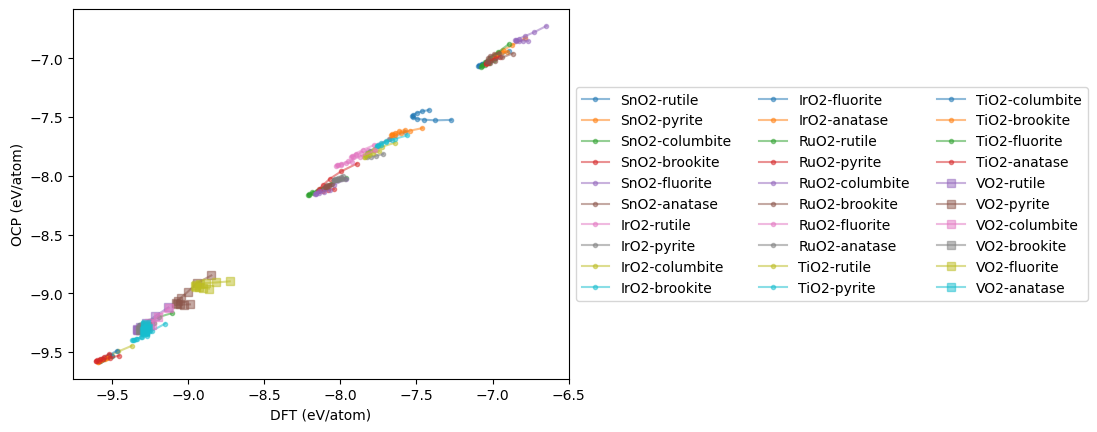

In [26]:
eos_data = {}
for oxide in oxides:
    eos_data[oxide] = {}
    for polymorph in polymorphs:
        dft = []
        ocp = []
        vols = []
        calculations = d[oxide][polymorph]['PBE']['EOS']['calculations']
        for c in calculations:
                        
            atoms = Atoms(symbols=c['atoms']['symbols'],
                          positions=c['atoms']['positions'],
                          cell=c['atoms']['cell'],
                          pbc=c['atoms']['pbc'])
            atoms.set_tags(np.ones(len(atoms)))
            
            atoms.calc = newcalc
            ocp += [atoms.get_potential_energy() / len(atoms)]
            dft += [c['data']['total_energy'] / len(atoms)]
            vols += [atoms.get_volume()]
        plt.plot(dft, ocp, marker='s' if oxide == 'VO2' else '.',
                 alpha=0.5, label=f'{oxide}-{polymorph}')
        eos_data[oxide][polymorph] = (vols, dft, ocp)
        
plt.xlabel('DFT (eV/atom)')
plt.ylabel('OCP (eV/atom)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=3);

In [28]:
mae = np.mean(np.abs(np.array(dft) - np.array(ocp)))
print(f'New MAE = {mae:1.3f} eV/atom')

New MAE = 0.025 eV/atom


This is a substantial improvement! We can see what it means in terms of the Equations of State. There is still not perfect agreement, but the curves are closer together. Additional fine tuning, or a better model could probably still improve this.

In [24]:
os.makedirs('finetuned-eos', exist_ok=True)
for oxide in eos_data:
    for polymorph in eos_data[oxide]:
        V, D, O = eos_data[oxide][polymorph]
        plt.figure()
        plt.plot(V, D, label='dft')
        plt.plot(V, O, label='ocp')
        plt.title(f'{oxide} - {polymorph}')
        plt.legend()
        plt.savefig(f'finetuned-eos/{oxide}-{polymorph}.png')
        plt.close()

Here is one example from [./finetuned-eos](./finetuned-eos).

![img](./finetuned-eos/VO2-fluorite.png)

It is possible to continue refining the fit. The simple things to do are to use more epochs of training. Eventually the MAE will stabilize, and then it may be necessary to adjust other optimization parameters like the learning rate (usually you decrease it). 

Depending on what is important to you, you may consider changing the relative importances of energy and forces; you can often trade off accuracy of one for the other. It may be necessary to add additional data to cover the composition and configuration space more thoroughly.

There are also other models you could consider. Newer models tend to be more accurate, but they may also be more expensive to run. These are all compromises you can consider.